<a href="https://colab.research.google.com/github/sashapff/bioinformatics-algorithms/blob/master/HW3_Trees.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Деревья решений решают проблемы
__Суммарное количество баллов: 10__

Вы уже знакомы с классификацией методом KNN. В этом задании предстоит реализовать другой метод классификации - дерево решений. 

Одной из его особенностей является возможность объяснить в человекочитаемой форме, почему мы отнесли объект к определенному классу. Эта особенность позволяет использовать деревья решений для создания систем, которые могут подсказывать специалистам, на что именно стоит обратить внимание при принятии решений.

In [ ]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import matplotlib
import math
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


### Задание 1 (1 балл)
Во время построения дерева решений нам потребуется определить, какой из предикатов лучше всего разбивает обучающую выборку. Есть два критерия, которые позволяют это сделать: критерий Джини и энтропийный критерий. Первый для подсчета информативности разбиения использует коэффициент Джини, второй - энтропию. Реализуйте подсчет этих коэффициентов, а так же подсчет информативности разбиения. 

#### Описание функций
`gini(x)` считает коэффициент Джини для массива меток

`entropy(x)` считает энтропию для массива меток

`gain(left_y, right_y, criterion)` считает информативность разбиения массива меток на левую `left_y` и правую `right_y` части при помощи `criterion`, который задается функцией (не строкой).

In [ ]:
def get_prob(x):
    classes_cnt = {}
    for i in x:
        if not i in classes_cnt:
            classes_cnt[i] = 0
        classes_cnt[i] += 1
    for key in classes_cnt:
        classes_cnt[key] /= len(x)
    return classes_cnt

def gini(x):
    classes_p = get_prob(x)
    res = 0
    for key in classes_p:
        p = classes_p[key] 
        res += p * (1 - p)
    return res
    
def entropy(x):
    classes_p = get_prob(x)
    res = 0
    for key in classes_p:
        p = classes_p[key] 
        res -= p * math.log(2, p)
    return res

def gain(left_y, right_y, criterion):
    y = np.concatenate((left_y, right_y), axis=0)
    return criterion(y) - (len(left_y) * criterion(left_y) + len(right_y) * criterion(right_y)) / len(y)

### Задание 2 (1 балл)
Деревья решений имеют хорошую интерпретируемость, т.к. позволяют не только предсказать класс, но и объяснить, почему мы предсказали именно его. Например, мы можем его нарисовать. Чтобы сделать это, нам необходимо знать, как оно устроено внутри. Реализуйте классы, которые будут задавать структуру дерева. 

#### DecisionTreeLeaf
Поля:
1. `y` должно содержать класс, который встречается чаще всего среди элементов листа дерева

#### DecisionTreeNode
В данной домашней работе мы ограничемся порядковыми и количественными признаками, поэтому достаточно хранить измерение и значение признака, по которому разбиваем обучающую выборку.

Поля:
1. `split_dim` измерение, по которому разбиваем выборку
2. `split_value` значение, по которому разбираем выборку
3. `left` поддерево, отвечающее за случай `x[split_dim] < split_value`. Может быть `DecisionTreeNode` или `DecisionTreeLeaf`
4. `right` поддерево, отвечающее за случай `x[split_dim] >= split_value`. Может быть `DecisionTreeNode` или `DecisionTreeLeaf`

__Интерфейс классов можно и нужно менять при необходимости__ (например, для вычисления вероятности в следующем задании)

In [ ]:
class DecisionTreeLeaf:
    def __init__(self, y):
        self.y = y

class DecisionTreeNode:
    def __init__(self, split_dim, split_value, left, right):
        self.split_dim = split_dim
        self.split_value = split_value
        self.left = left
        self.right = right

### Задание 3 (6 баллов)
Теперь перейдем к самому дереву решений. Реализуйте класс `DecisionTreeClassifier`.

#### Описание методов
`fit(X, y)` строит дерево решений по обучающей выборке.

`predict_proba(X)` для каждого элемента из `X` возвращает словарь `dict`, состоящий из пар `(класс, вероятность)`. Вероятности классов в листе можно определить через количество объектов соответствующего класса в листе. 

#### Описание параметров конструктора
`criterion="gini"` - задает критерий, который будет использоваться при построении дерева. Возможные значения: `"gini"`, `"entropy"`.

`max_depth=None` - ограничение глубины дерева. Если `None` - глубина не ограничена

`min_samples_leaf=1` - минимальное количество элементов в каждом листе дерева.

#### Описание полей
`root` - корень дерева. Может быть `DecisionTreeNode` или `DecisionTreeLeaf`

In [87]:
class DecisionTreeClassifier:
    def __init__(self, criterion="gini", max_depth=None, min_samples_leaf=1):
        self.root = None
        if criterion == 'gini':
            self.criterion = gini
        elif criterion == 'entropy':
            self.criterion = entropy
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf

    def fit_recursive(self, X, y, depth):
        if depth == self.max_depth or len(np.unique(y.to_numpy())) == 1:
            return DecisionTreeLeaf(y.to_numpy())
        max_gain = -10**10
        max_dim = 0
        max_ind = 0
        max_value = 0
        for ind, dim in enumerate(X.columns):
            for value in np.unique(X[dim].to_numpy()):
                left_y = y.loc[X[dim] < value]
                right_y = y.loc[X[dim] >= value]
                if len(left_y) >= self.min_samples_leaf and len(right_y) >= self.min_samples_leaf:
                    gain_value = gain(left_y, right_y, self.criterion)
                    if gain_value > max_gain:
                        max_gain = gain_value
                        max_dim = dim
                        max_ind = ind
                        max_value = value
        if max_gain == -10**10:
            return DecisionTreeLeaf(y.to_numpy())
        left = self.fit_recursive(X.loc[X[max_dim] < max_value], y.loc[X[max_dim] < max_value], depth + 1)
        right = self.fit_recursive(X.loc[X[max_dim] >= max_value], y.loc[X[max_dim] >= max_value], depth + 1)
        return DecisionTreeNode(max_ind, max_value, left, right)
                    
    def fit(self, X, y):
        self.root = self.fit_recursive(X, y, 0)

    def predict_proba_element(self, node, x):
        if isinstance(node, DecisionTreeNode):
            if x[node.split_dim] < node.split_value:
                return self.predict_proba_element(node.left, x)
            else:
                return self.predict_proba_element(node.right, x)
        else:
            return get_prob(node.y)
    
    def predict_proba(self, X):
        predictions = []
        for ind, x in X.iterrows():
            predictions.append(self.predict_proba_element(self.root, x.to_numpy()))
        return predictions
    
    def predict(self, X):
        proba = self.predict_proba(X)
        return [max(p.keys(), key=lambda k: p[k]) for p in proba]

Построенное дерево можно нарисовать. Метод `draw_tree` рисует дерево и сохраняет его в указанный файл.

In [ ]:
def tree_depth(tree_root):
    if isinstance(tree_root, DecisionTreeNode):
        return max(tree_depth(tree_root.left), tree_depth(tree_root.right)) + 1
    else:
        return 1

def draw_tree_rec(tree_root, x_left, x_right, y):
    x_center = (x_right - x_left) / 2 + x_left
    if isinstance(tree_root, DecisionTreeNode):
        x_center = (x_right - x_left) / 2 + x_left
        x = draw_tree_rec(tree_root.left, x_left, x_center, y - 1)
        plt.plot((x_center, x), (y - 0.1, y - 0.9), c=(0, 0, 0))
        x = draw_tree_rec(tree_root.right, x_center, x_right, y - 1)
        plt.plot((x_center, x), (y - 0.1, y - 0.9), c=(0, 0, 0))
        plt.text(x_center, y, "x[%i] < %f" % (tree_root.split_dim, tree_root.split_value),
                horizontalalignment='center')
    else:
        plt.text(x_center, y, str(tree_root.y),
                horizontalalignment='center')
    return x_center

def draw_tree(tree, save_path=None):
    td = tree_depth(tree.root)
    plt.figure(figsize=(0.33 * 2 ** td, 2 * td))
    plt.xlim(-1, 1)
    plt.ylim(0.95, td + 0.05)
    plt.axis('off')
    draw_tree_rec(tree.root, -1, 1, td)
    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path)
    plt.show()

Для двумерного набора данных дерево можно отобразить на плоскости с данными. Кроме того, как и для любого классификатора, для него можно построить roc-кривую

In [ ]:
def plot_roc_curve(y_test, p_pred):
    positive_samples = sum(1 for y in y_test if y == 0)
    tpr = []
    fpr = []
    for w in np.arange(-0.01, 1.02, 0.01):
        y_pred = [(0 if p.get(0, 0) > w else 1) for p in p_pred]
        tpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt == 0) / positive_samples)
        fpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt != 0) / (len(y_test) - positive_samples))
    plt.figure(figsize = (7, 7))
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.xlim(-0.01, 1.01)
    plt.ylim(-0.01, 1.01)
    plt.tight_layout()
    plt.show()

def rectangle_bounds(bounds):
    return ((bounds[0][0], bounds[0][0], bounds[0][1], bounds[0][1]), 
            (bounds[1][0], bounds[1][1], bounds[1][1], bounds[1][0]))

def plot_2d_tree(tree_root, bounds, colors):
    if isinstance(tree_root, DecisionTreeNode):
        if tree_root.split_dim:
            plot_2d_tree(tree_root.left, [bounds[0], [bounds[1][0], tree_root.split_value]], colors)
            plot_2d_tree(tree_root.right, [bounds[0], [tree_root.split_value, bounds[1][1]]], colors)
            plt.plot(bounds[0], (tree_root.split_value, tree_root.split_value), c=(0, 0, 0))
        else:
            plot_2d_tree(tree_root.left, [[bounds[0][0], tree_root.split_value], bounds[1]], colors)
            plot_2d_tree(tree_root.right, [[tree_root.split_value, bounds[0][1]], bounds[1]], colors)
            plt.plot((tree_root.split_value, tree_root.split_value), bounds[1], c=(0, 0, 0))
    else:
        x, y = rectangle_bounds(bounds)
        plt.fill(x, y, c=colors[tree_root.y] + [0.2])

def plot_2d(tree, X, y):
    plt.figure(figsize=(9, 9))
    colors = dict((c, list(np.random.random(3))) for c in np.unique(y))
    bounds = list(zip(np.min(X, axis=0), np.max(X, axis=0)))
    plt.xlim(*bounds[0])
    plt.ylim(*bounds[1])
    plot_2d_tree(tree.root, list(zip(np.min(X, axis=0), np.max(X, axis=0))), colors)
    for c in np.unique(y):
        plt.scatter(X[y==c, 0], X[y==c, 1], c=[colors[c]], label=c)
    plt.legend()
    plt.tight_layout()
    plt.show()

## Задание 4 (2 балла)

Протестируйте решение на данных cancer и spam (датасеты из директории `hw2_data`).
Выполните загрузку и предобработку данных.


Если необходимо, попробуйте разные наборы параметров для получения лучшего результата.

Посчитайте метрики `precision`, `recall`, `accuracy` для модели дерева.
Сравните значения метрик с результатами модели kNN из предыдущего задания (можно использовать реализацию из библиотеки `sklearn`). 

Какой нужен препроцессинг данных для моделей?
Какая модель делает предсказания лучше?  Предположите, почему.

Значение метрик для параметров `max_depth=5, min_samples_leaf=30` вполне удовлетверительны, так что я не подбирала гиперпараметры. И для первого датасета, и для второго дерево по всем метрикам классифицирует лучше метода ближайших соседей. В отличие от `Knn` деревья не требуют предворительного препроцессинга данных, такого как нормализация или скалирование, потому что разделение по признакам идет независимо. Я думаю, что хорошее качество моделей, основанных на деревьях заключается в том, что на каждом шаге они учитывают весь набор данных в узле, а не только значения фиксированного значения ближайших точек.

In [ ]:
from sklearn.metrics import accuracy_score, \
                            recall_score, precision_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split as sklearn_train_test_split

In [ ]:
CANCER_DATA_PATH = '/content/drive/My Drive/bioinf/ml/hw2_data/cancer.csv'
SPAM_DATA_PATH = '/content/drive/My Drive/bioinf/ml/hw2_data/spam.csv'

In [ ]:
def read_cancer_dataset(path_to_csv):
    # Возвращает пару из X и y. X - массив векторов. y - соответствующие векторам метки
    dataset = pd.read_csv(path_to_csv)
    X = dataset.drop("label", axis=1)
    y = dataset.label.map({'B': 0, 'M': 1})
    return X, y

def read_spam_dataset(path_to_csv):
    # Возвращает пару из X и y. X - массив векторов. y - соответствующие векторам метки
    dataset = pd.read_csv(path_to_csv)
    X = dataset.drop("label", axis=1)
    y = dataset.label
    return X, y

In [ ]:
def train_test_split(X, y, ratio=0.9):
    # Возвращает X_train, X_test, y_train, y_test
    # X_train и X_test - массив векторов - две части массива X, разделенного в состветсви с коэффициентом ratio
    # y_train и y_test - соответствующие X_train и X_test метки классов
    X_train, X_test, y_train, y_test = sklearn_train_test_split(X, y, test_size=1-ratio)
    return X_train, y_train, X_test, y_test

In [ ]:
X_cancer, y_cancer = read_cancer_dataset(CANCER_DATA_PATH)
X_spam, y_spam = read_spam_dataset(SPAM_DATA_PATH)

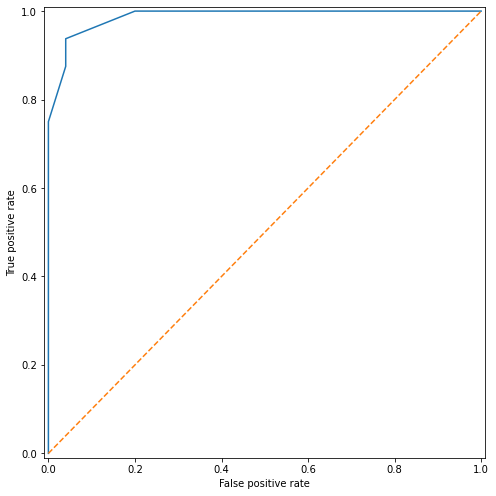

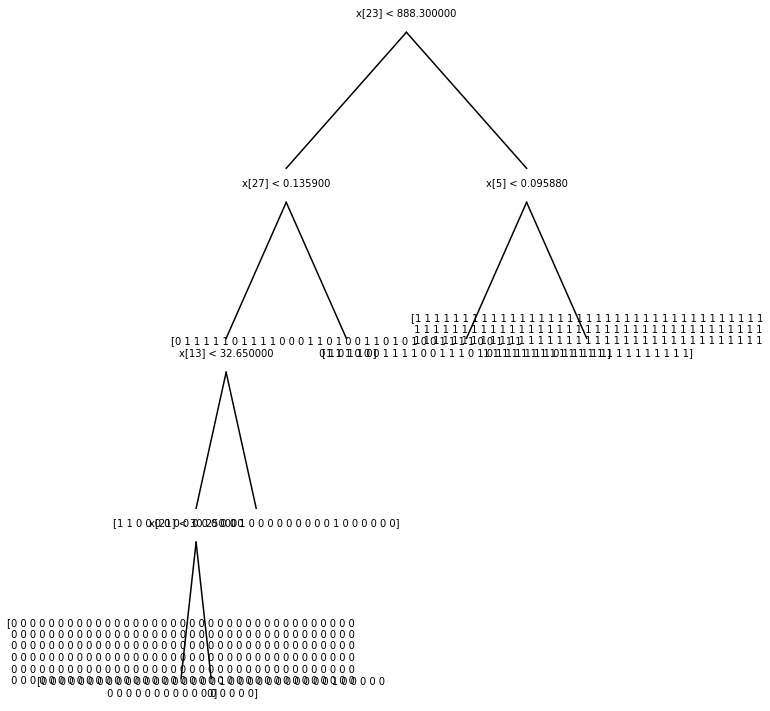

In [99]:
X_train, y_train, X_test, y_test = train_test_split(X_cancer, y_cancer, 0.9)
tree = DecisionTreeClassifier(max_depth=5, min_samples_leaf=30)
tree.fit(X_train, y_train)
plot_roc_curve(y_test, tree.predict_proba(X_test))
draw_tree(tree)

In [100]:
predictions = tree.predict(X_test)
print(f'Tree precision: {precision_score(y_test, predictions)}')
print(f'Tree recall: {recall_score(y_test, predictions)}')
print(f'Tree accuracy: {accuracy_score(y_test, predictions)}')

Tree precision: 0.9230769230769231
Tree recall: 0.96
Tree accuracy: 0.9473684210526315


In [101]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
predictions = knn.predict(X_test)
print(f'Knn precision: {precision_score(y_test, predictions)}')
print(f'Knn recall: {recall_score(y_test, predictions)}')
print(f'Knn accuracy: {accuracy_score(y_test, predictions)}')

Knn precision: 1.0
Knn recall: 0.88
Knn accuracy: 0.9473684210526315


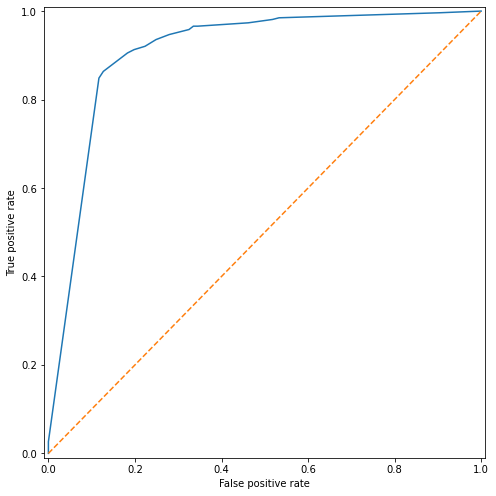

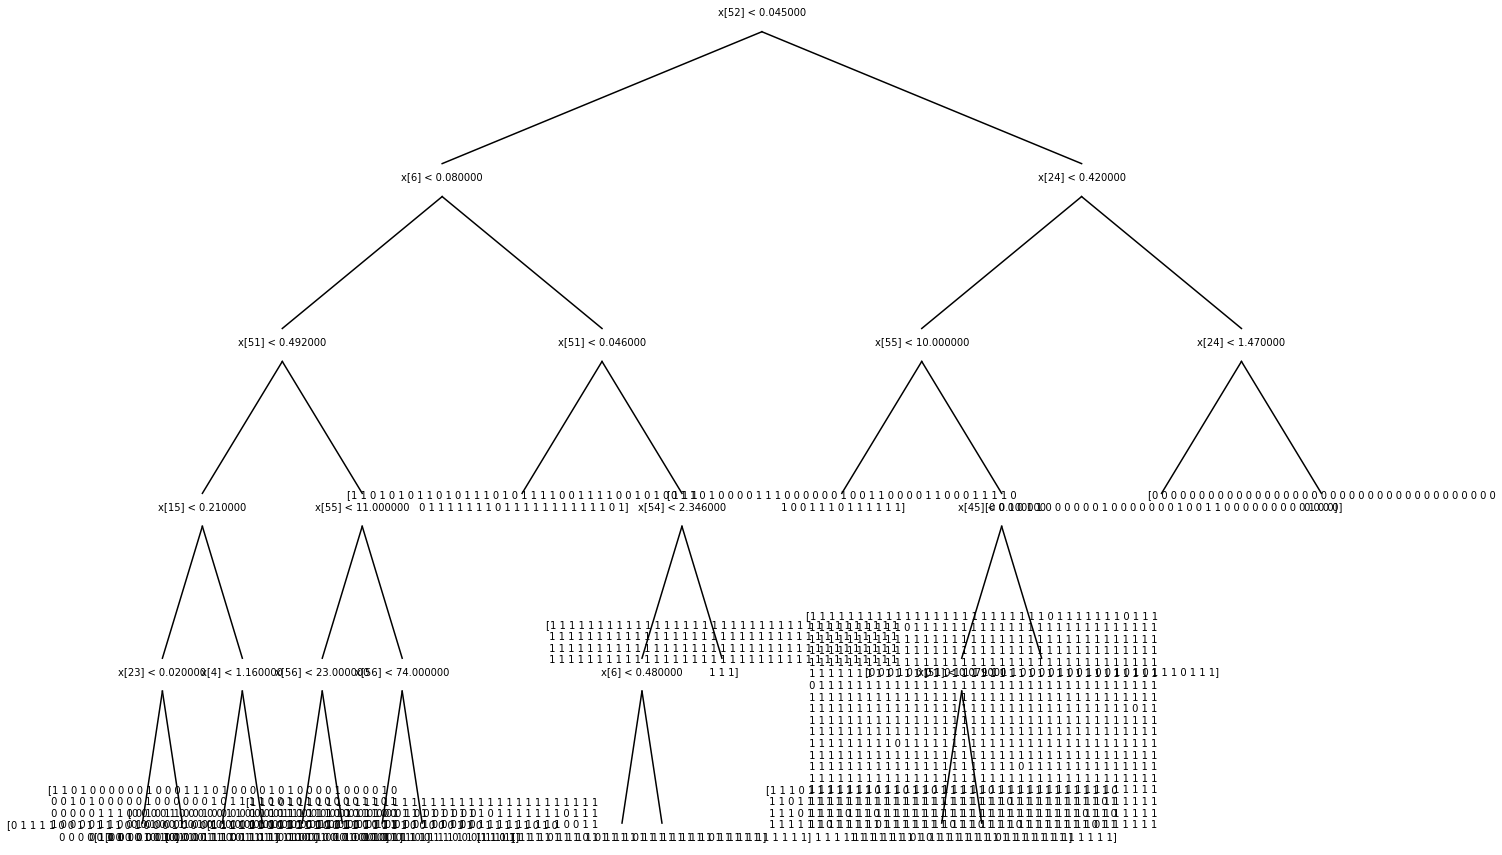

In [96]:
X_train, y_train, X_test, y_test = train_test_split(X_spam, y_spam, 0.9)
tree = DecisionTreeClassifier(max_depth=5, min_samples_leaf=30)
tree.fit(X_train, y_train)
plot_roc_curve(y_test, tree.predict_proba(X_test))
draw_tree(tree)

In [98]:
print(f'Tree precision: {precision_score(y_test, tree.predict(X_test))}')
print(f'Tree recall: {recall_score(y_test, tree.predict(X_test))}')
print(f'Tree accuracy: {accuracy_score(y_test, tree.predict(X_test))}')

Tree precision: 0.8729281767955801
Tree recall: 0.8020304568527918
Tree accuracy: 0.8655097613882863


In [97]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
predictions = knn.predict(X_test)
print(f'Knn precision: {precision_score(y_test, predictions)}')
print(f'Knn recall: {recall_score(y_test, predictions)}')
print(f'Knn accuracy: {accuracy_score(y_test, predictions)}')

Knn precision: 0.7894736842105263
Knn recall: 0.6852791878172588
Knn accuracy: 0.7874186550976139
